In [ ]:
!pip install torch torch-geometric scikit-learn pandas networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import numpy
print(numpy.__version__)

2.0.2


In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124


In [ ]:
# Torch-scatter and torch-sparse compatible with torch==2.6.0+cu124
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html -q
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Load data
df = pd.read_excel("/content/drive/MyDrive/Malware/NEWOutput1.xlsx")

# Extract features and labels
features = df.iloc[:, 1:].values
filenames = df['Filename']

# Encode labels (e.g., 'Spyware-TIBS' -> 'Spyware')
labels = filenames.str.extract(r'(\w+)-')[0]
le = LabelEncoder()
y = le.fit_transform(labels)

# Scale features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Create edges based on similarity
sim_matrix = cosine_similarity(features)
k = 5  # k nearest neighbors

# Creating time windows of 10 rows each (85 windows for 851 rows)
window_size = 10
num_windows = len(df) // window_size  # Total windows = 851 / 10 = 85
data_list = []
# Create a writer object to write data to a single Excel file
with pd.ExcelWriter('/content/drive/MyDrive/Malware/all_windows_data.xlsx') as writer:
    # Store data for each time window in a list
    for window in range(num_windows):
        start_idx = window * window_size
        end_idx = (window + 1) * window_size

        # Extract features for the current window
        window_features = features[start_idx:end_idx]
        window_labels = y[start_idx:end_idx]

        # Create a similarity matrix for this window
        sim_matrix_window = cosine_similarity(window_features)

        # Generate edges for this window based on similarity
        edge_index_window = []
        for i in range(len(sim_matrix_window)):
            top_k = np.argsort(sim_matrix_window[i])[-(k+1):-1]  # Skip self-loop
            for j in top_k:
                edge_index_window.append([i, j])

        # Convert to tensor
        edge_index_window = torch.tensor(edge_index_window, dtype=torch.long).t().contiguous()
        x_window = torch.tensor(window_features, dtype=torch.float)
        y_window = torch.tensor(window_labels, dtype=torch.long)

        # Create PyG Data object for this window
        data_window = Data(x=x_window, edge_index=edge_index_window, y=y_window)
        # Append this window data to the list
        data_list.append(data_window)
        # Convert x (features) to DataFrame and save to Excel (one sheet per window)
        df_x = pd.DataFrame(x_window.numpy())  # Convert tensor to numpy and then to DataFrame
        df_x.to_excel(writer, sheet_name=f'Window_{window}_Features', index=False)

        # Convert edge_index (edges) to DataFrame (source, target) and save to Excel
        df_edges = pd.DataFrame(edge_index_window.numpy().T, columns=["Source", "Target"])
        df_edges.to_excel(writer, sheet_name=f'Window_{window}_Edges', index=False)

        # Convert y (labels) to DataFrame and save to Excel
        df_y = pd.DataFrame(y_window.numpy(), columns=["Labels"])
        df_y.to_excel(writer, sheet_name=f'Window_{window}_Labels', index=False)

# The Excel file will now contain multiple sheets: one for each window's features, edges, and labels


Mounted at /content/drive


 Step 1: Dynamic Graph Learning with GraphSAGE

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

# Sample GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


 Train over multiple windows

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.nn import GraphSAGE  # Make sure GraphSAGE is imported
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set device to CPU
device = torch.device("cpu")

# Set model parameters
in_channels = data_list[0].num_node_features
hidden_channels = 32
out_channels = len(set(y))  # number of unique labels

# Define the model
model = GraphSAGE(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# For plotting
loss_values = []
accuracy_values = []

# Train model on each window
model.train()
for epoch in range(20):  # number of training epochs
    total_loss = 0
    all_preds = []
    all_labels = []

    for data in data_list:
        data = data.to(device)
        optimizer.zero_grad()

        out = model(data.x, data.edge_index)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 173.8658
Epoch 2, Loss: 162.7289
Epoch 3, Loss: 154.8424
Epoch 4, Loss: 148.0088
Epoch 5, Loss: 142.0589
Epoch 6, Loss: 136.7385
Epoch 7, Loss: 131.8487
Epoch 8, Loss: 127.2670
Epoch 9, Loss: 122.9159
Epoch 10, Loss: 118.7442
Epoch 11, Loss: 114.7172
Epoch 12, Loss: 110.8106
Epoch 13, Loss: 107.0073
Epoch 14, Loss: 103.2953
Epoch 15, Loss: 99.6660
Epoch 16, Loss: 96.1137
Epoch 17, Loss: 92.6344
Epoch 18, Loss: 89.2255
Epoch 19, Loss: 85.8858
Epoch 20, Loss: 82.6146


In [ ]:
print(data.x.shape)
# Output: torch.Size([1000, 16]) -> feature_dim = 16


torch.Size([10, 55])


In [ ]:
num_classes = len(torch.unique(data.y))
print(num_classes)


1


GraphSAGE is imported:

In [ ]:
from torch_geometric.nn import GraphSAGE

Basic Accuracy

In [ ]:
# Evaluate on all windows using CPU
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in data_list:
        data = data.to("cpu")  # Set device to CPU
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.num_nodes

print(f"Accuracy: {correct / total * 100:.2f}%")
import torch

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Path to save the PyG data object
save_path = '/content/drive/MyDrive/Malware/graph_data.pt'

# Save the PyG Data object
torch.save(data_list, save_path)

print(f"Saved graph_data to {save_path}")


Accuracy: 94.40%
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved graph_data to /content/drive/MyDrive/Malware/graph_data.pt


Causal Sampling (Temporal Neighbor Selection)

Updated Training Loop with Causal Sampling:

Epoch 1, Causal Loss: 334.9587
Epoch 1, Causal Loss: 334.9587, Accuracy: 40.20%
Epoch 2, Causal Loss: 309.7313
Epoch 2, Causal Loss: 309.7313, Accuracy: 49.80%
Epoch 3, Causal Loss: 294.3856
Epoch 3, Causal Loss: 294.3856, Accuracy: 54.29%
Epoch 4, Causal Loss: 281.9296
Epoch 4, Causal Loss: 281.9296, Accuracy: 57.76%
Epoch 5, Causal Loss: 271.2290
Epoch 5, Causal Loss: 271.2290, Accuracy: 57.35%
Epoch 6, Causal Loss: 261.6215
Epoch 6, Causal Loss: 261.6215, Accuracy: 58.57%
Epoch 7, Causal Loss: 252.7498
Epoch 7, Causal Loss: 252.7498, Accuracy: 64.90%
Epoch 8, Causal Loss: 244.3989
Epoch 8, Causal Loss: 244.3989, Accuracy: 73.06%
Epoch 9, Causal Loss: 236.4308
Epoch 9, Causal Loss: 236.4308, Accuracy: 79.80%
Epoch 10, Causal Loss: 228.7536
Epoch 10, Causal Loss: 228.7536, Accuracy: 83.67%
Epoch 11, Causal Loss: 221.3054
Epoch 11, Causal Loss: 221.3054, Accuracy: 86.53%
Epoch 12, Causal Loss: 214.0448
Epoch 12, Causal Loss: 214.0448, Accuracy: 87.14%
Epoch 13, Causal Loss: 206.9441
Ep

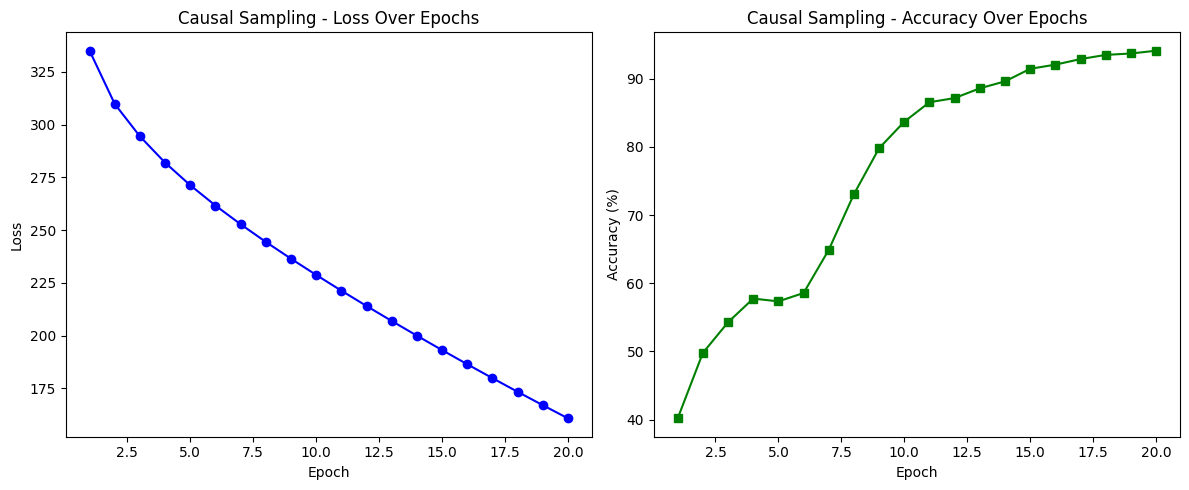

In [ ]:
from torch_geometric.nn import GraphSAGE
import torch
import torch.nn.functional as F
losses = []
accuracies = []

# Re-initialize the model for causal training
in_channels = data_list[0].num_node_features
hidden_channels = 32
out_channels = len(set(y))
model = GraphSAGE(in_channels, hidden_channels, out_channels).to("cpu")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Causal training: Only train on current and previous windows
model.train()
for epoch in range(20):  # Number of epochs
    total_loss = 0
    for t in range(1, len(data_list)):  # Start from t=1 to allow causal (t-1)
        optimizer.zero_grad()

        # Simulate causal memory: train on window t-1
        past_data = data_list[t - 1].to("cpu")
        current_data = data_list[t].to("cpu")

        # Forward on past data
        out_past = model(past_data.x, past_data.edge_index)
        loss_past = loss_fn(out_past, past_data.y)

        # Forward on current data
        out_current = model(current_data.x, current_data.edge_index)
        loss_current = loss_fn(out_current, current_data.y)

        # Combined loss
        loss = loss_past + loss_current
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Causal Loss: {total_loss:.4f}")
  # Calculate accuracy after epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for t in range(1, len(data_list)):
            data = data_list[t].to("cpu")
            out = model(data.x, data.edge_index)
            preds = out.argmax(dim=1)
            correct += (preds == data.y).sum().item()
            total += data.y.size(0)

    accuracy = correct / total if total > 0 else 0
    losses.append(total_loss)
    accuracies.append(accuracy * 100)

    print(f"Epoch {epoch+1}, Causal Loss: {total_loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    model.train()  # switch back to training mode

# Plotting
epochs = list(range(1, 21))
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o', color='blue')
plt.title('Causal Sampling - Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, marker='s', color='green')
plt.title('Causal Sampling - Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

Evaluation After Causal Training:

In [ ]:
# Evaluate only on the last window (simulate unseen future)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    eval_data = data_list[-1].to("cpu")  # Last window
    out = model(eval_data.x, eval_data.edge_index)
    pred = out.argmax(dim=1)
    correct += (pred == eval_data.y).sum().item()
    total += eval_data.num_nodes

print(f"Causal Evaluation Accuracy (on last window): {correct / total * 100:.2f}%")


Causal Evaluation Accuracy (on last window): 80.00%


In [ ]:
import copy
import random
import torch
num_output_classes = 2
out_channels = num_output_classes

def inject_noise(data_list, label_noise_ratio=0.1, feature_noise_ratio=0.1, num_output_classes=2): # Add this parameter
    noisy_data_list = []

    for data in data_list:
        data_noisy = copy.deepcopy(data)

        # Ensure label has multiple classes before injecting noise
        # Now, ensure labels are within the range [0, num_output_classes - 1]
        unique_labels = list(set(data_noisy.y.tolist()))
        if len(unique_labels) <= 1:
            # Randomly assign labels from 0 to num_output_classes - 1
            data_noisy.y = torch.randint(0, num_output_classes, data_noisy.y.shape, dtype=torch.long)
            unique_labels = list(set(data_noisy.y.tolist())) # Recalculate unique_labels

        num_nodes = data_noisy.y.shape[0]

        # Inject label noise
        num_label_noise = int(label_noise_ratio * num_nodes)
        noisy_label_indices = random.sample(range(num_nodes), num_label_noise)

        for idx in noisy_label_indices:
            original_label = data_noisy.y[idx].item()
            # Ensure possible_labels are within the defined output classes
            possible_labels = list(range(num_output_classes)) # All possible classes
            if len(possible_labels) <= 1: # If only one class is possible, no noise can be injected
                continue

            # Filter out the original label, but handle cases where original_label might not be in possible_labels (though it should be now)
            if original_label in possible_labels:
                possible_labels.remove(original_label)

            # If after removing original, no other options are left (e.g., if num_output_classes was 1), skip
            if not possible_labels:
                continue

            new_label = random.choice(possible_labels)
            data_noisy.y[idx] = new_label

        # Inject feature noise (this part is fine)
        num_feature_noise = int(feature_noise_ratio * num_nodes)
        noisy_feature_indices = random.sample(range(num_nodes), num_feature_noise)

        for idx in noisy_feature_indices:
            noise = torch.randn_like(data_noisy.x[idx]) * 0.1
            data_noisy.x[idx] += noise

        noisy_data_list.append(data_noisy)

    return noisy_data_list


# Apply noise
noisy_data_list = inject_noise(data_list, label_noise_ratio=0.1, feature_noise_ratio=0.1)

# Add time_window attribute to each data object (make sure it's a CPU tensor)
# Assign dummy time_window values to each graph
for i, data in enumerate(noisy_data_list):
    num_nodes = data.num_nodes
    # Example: assign random time values or based on your use case
    data.time_window = torch.randint(0, 5, (num_nodes,), dtype=torch.long)


import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class CausalGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CausalGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, time_window):
        row, col = edge_index

        # Filter edges: allow edges from past or current windows only (causal)
        mask = time_window[row] <= time_window[col]
        if mask.sum() == 0:
            # If all edges filtered out, skip filtering to avoid empty edge_index
            filtered_edge_index = edge_index
        else:
            filtered_edge_index = edge_index[:, mask]

        x = F.relu(self.conv1(x, filtered_edge_index))
        x = self.conv2(x, filtered_edge_index)
        return x


# Model setup
model = CausalGraphSAGE(in_channels, hidden_channels, out_channels).to("cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(20):
    total_loss = 0
    for t in range(1, len(noisy_data_list)):
        optimizer.zero_grad()
        past_data = noisy_data_list[t - 1].to("cpu")
        current_data = noisy_data_list[t].to("cpu")

        out_past = model(past_data.x, past_data.edge_index, past_data.time_window)
        loss_past = loss_fn(out_past, past_data.y)

        out_current = model(current_data.x, current_data.edge_index, current_data.time_window)
        loss_current = loss_fn(out_current, current_data.y)

        loss = loss_past + loss_current
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Noise] Epoch {epoch+1}, Causal Loss: {total_loss:.4f}")

print("Example past labels:", past_data.y)
print("Example current labels:", current_data.y)


[Noise] Epoch 1, Causal Loss: 70.7711
[Noise] Epoch 2, Causal Loss: 68.9621
[Noise] Epoch 3, Causal Loss: 68.1443
[Noise] Epoch 4, Causal Loss: 67.6062
[Noise] Epoch 5, Causal Loss: 67.2066
[Noise] Epoch 6, Causal Loss: 66.8582
[Noise] Epoch 7, Causal Loss: 66.5371
[Noise] Epoch 8, Causal Loss: 66.2524
[Noise] Epoch 9, Causal Loss: 66.0225
[Noise] Epoch 10, Causal Loss: 65.8063
[Noise] Epoch 11, Causal Loss: 65.6065
[Noise] Epoch 12, Causal Loss: 65.4279
[Noise] Epoch 13, Causal Loss: 65.2576
[Noise] Epoch 14, Causal Loss: 65.1049
[Noise] Epoch 15, Causal Loss: 64.9555
[Noise] Epoch 16, Causal Loss: 64.8158
[Noise] Epoch 17, Causal Loss: 64.6795
[Noise] Epoch 18, Causal Loss: 64.5557
[Noise] Epoch 19, Causal Loss: 64.4242
[Noise] Epoch 20, Causal Loss: 64.3064
Example past labels: tensor([0, 0, 0, 0, 1, 0, 1, 1, 1, 0])
Example current labels: tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 0])


Inject 10–20% Noise for Robustness Testing

We’ll inject:

Label noise: randomly flip labels for 10–20% of nodes.

Feature noise: add small Gaussian noise to features for 10–20% of nodes.

In [ ]:
import copy
import random
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# --- Define the number of output classes for your problem ---
# This is crucial and must match your target labels.
# For binary classification (e.g., benign/malicious), it's 2.
# If you have 3 types of malware + benign, it would be 4.
num_output_classes = 2 # Adjust this based on your actual classification task

def inject_noise(data_list, label_noise_ratio=0.1, feature_noise_ratio=0.1, num_output_classes=2):
    noisy_data_list = []

    for data in data_list:
        data_noisy = copy.deepcopy(data)

        num_nodes = data_noisy.y.shape[0]

        # Ensure original labels are within the expected range, or re-assign if necessary
        # The .to(torch.long) is important for CrossEntropyLoss
        # If your initial data.y values are not 0 to num_output_classes-1, you might need a mapping here
        # For demonstration, we'll ensure they are if they are not.
        if len(set(data_noisy.y.tolist())) <= 1 or max(data_noisy.y.tolist()) >= num_output_classes:
            print(f"Warning: Adjusting labels in data sample {data_list.index(data)} to fit {num_output_classes} classes.")
            data_noisy.y = torch.randint(0, num_output_classes, data_noisy.y.shape, dtype=torch.long)

        # Inject label noise
        num_label_noise = int(label_noise_ratio * num_nodes)
        noisy_label_indices = random.sample(range(num_nodes), num_label_noise)

        for idx in noisy_label_indices:
            original_label = data_noisy.y[idx].item()

            # Get all possible target labels (0 to num_output_classes - 1)
            possible_labels_for_noise = list(range(num_output_classes))

            # Remove the original label to ensure we change it
            if original_label in possible_labels_for_noise:
                possible_labels_for_noise.remove(original_label)

            # If after removal, there are no other options, skip noise injection for this label
            if not possible_labels_for_noise:
                continue

            new_label = random.choice(possible_labels_for_noise)
            data_noisy.y[idx] = new_label

        # Inject feature noise
        num_feature_noise = int(feature_noise_ratio * num_nodes)
        noisy_feature_indices = random.sample(range(num_nodes), num_feature_noise)

        for idx in noisy_feature_indices:
            # Ensure noise type matches feature type (e.g., float)
            noise = torch.randn_like(data_noisy.x[idx]) * 0.6
            data_noisy.x[idx] += noise

        noisy_data_list.append(data_noisy)

    return noisy_data_list

# Add time_window attribute to each data object (make sure it's a CPU tensor)
# Assign dummy time_window values to each graph
# THIS PART NEEDS TO BE DONE AFTER YOUR ACTUAL data_list IS LOADED AND CREATED.
# For demonstration purposes, let's assume data_list is already defined with Data objects
# Example:
# from torch_geometric.data import Data
# data_list = [
#     Data(x=torch.randn(10, 16), edge_index=torch.randint(0, 10, (2, 20)), y=torch.randint(0, 2, (10,))),
#     Data(x=torch.randn(12, 16), edge_index=torch.randint(0, 12, (2, 25)), y=torch.randint(0, 2, (12,))),
# ]
# Make sure data_list exists and contains torch_geometric.data.Data objects with x, edge_index, y

# Infer in_channels from your actual data_list
# If data_list is empty, this will cause an error. Ensure it's populated.
if not data_list:
    raise ValueError("data_list is empty. Please ensure it's populated with PyG Data objects.")
in_channels = data_list[0].x.shape[1] # Number of features per node
hidden_channels = 32
out_channels = num_output_classes # This must match your target labels

# Apply noise
# Pass num_output_classes to the inject_noise function
noisy_data_list = inject_noise(data_list, label_noise_ratio=0.3, feature_noise_ratio=0.3, num_output_classes=num_output_classes)

# Add time_window attribute to each data object (make sure it's a CPU tensor)
# This loop should ideally come AFTER `inject_noise` if `inject_noise` creates new Data objects.
# Or ensure that `data_list` itself already has `time_window`
for i, data in enumerate(noisy_data_list):
    num_nodes = data.num_nodes
    data.time_window = torch.randint(0, 5, (num_nodes,), dtype=torch.long) # Example: assign random time values


class CausalGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CausalGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, time_window):
        row, col = edge_index

        # Filter edges: allow edges from past or current windows only (causal)
        # Handle cases where time_window might not contain all node indices
        if len(time_window) > 0: # Ensure time_window is not empty before indexing
            mask = time_window[row] <= time_window[col]
            if mask.sum() == 0 and edge_index.numel() > 0: # If all edges filtered, but edges existed, don't filter
                 filtered_edge_index = edge_index
            else:
                 filtered_edge_index = edge_index[:, mask]
        else: # If no time window information, use all edges (non-causal)
            filtered_edge_index = edge_index

        # Handle empty filtered_edge_index if no edges remain
        if filtered_edge_index.numel() == 0 and x.numel() > 0:
            # If no edges, but nodes exist, SAGEConv might complain.
            # A common workaround is to return a default output or handle this in SAGEConv.
            # For now, let's assume SAGEConv can handle empty edge_index if x is valid.
            # If it still errors, you might need to add a check for x.numel() > 0
            # and potentially return a zero tensor if both edge_index and x are problematic.
            pass

        x = F.relu(self.conv1(x, filtered_edge_index))
        x = self.conv2(x, filtered_edge_index)
        return x


# Model setup
model = CausalGraphSAGE(in_channels, hidden_channels, out_channels).to("cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-10)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(20):
    total_loss = 0
    # Ensure noisy_data_list is not empty and has at least 2 elements for t-1, t
    if len(noisy_data_list) < 2:
        print("Not enough data samples in noisy_data_list for causal training.")
        break # Exit loop if not enough data

    for t in range(1, len(noisy_data_list)):
        optimizer.zero_grad()
        past_data = noisy_data_list[t - 1].to("cpu")
        current_data = noisy_data_list[t].to("cpu")

        # Ensure labels are torch.long for CrossEntropyLoss
        # This is critical for CrossEntropyLoss!
        if past_data.y.dtype != torch.long:
            past_data.y = past_data.y.long()
        if current_data.y.dtype != torch.long:
            current_data.y = current_data.y.long()

        # Check if any data.y values are out of bounds before passing to loss_fn
        if past_data.y.max() >= out_channels or past_data.y.min() < 0:
            print(f"Error: Past data labels out of bounds for epoch {epoch}, t {t}. Max label: {past_data.y.max()}, Min label: {past_data.y.min()}, Expected range: [0, {out_channels-1}]")
            continue # Skip this iteration or handle appropriately

        if current_data.y.max() >= out_channels or current_data.y.min() < 0:
            print(f"Error: Current data labels out of bounds for epoch {epoch}, t {t}. Max label: {current_data.y.max()}, Min label: {current_data.y.min()}, Expected range: [0, {out_channels-1}]")
            continue # Skip this iteration or handle appropriately


        out_past = model(past_data.x, past_data.edge_index, past_data.time_window)
        loss_past = loss_fn(out_past, past_data.y)

        out_current = model(current_data.x, current_data.edge_index, current_data.time_window)
        loss_current = loss_fn(out_current, current_data.y)

        loss = loss_past + loss_current
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Noise] Epoch {epoch+1}, Causal Loss: {total_loss:.4f}")

print("Example past labels:", past_data.y)
print("Example current labels:", current_data.y)

[Noise] Epoch 1, Causal Loss: 79.6671
[Noise] Epoch 2, Causal Loss: 71.1445
[Noise] Epoch 3, Causal Loss: 65.9170
[Noise] Epoch 4, Causal Loss: 64.1407
[Noise] Epoch 5, Causal Loss: 62.8427
[Noise] Epoch 6, Causal Loss: 60.4615
[Noise] Epoch 7, Causal Loss: 61.4896
[Noise] Epoch 8, Causal Loss: 57.5988
[Noise] Epoch 9, Causal Loss: 57.2948
[Noise] Epoch 10, Causal Loss: 56.3715
[Noise] Epoch 11, Causal Loss: 56.6747
[Noise] Epoch 12, Causal Loss: 51.6357
[Noise] Epoch 13, Causal Loss: 49.8622
[Noise] Epoch 14, Causal Loss: 46.2705
[Noise] Epoch 15, Causal Loss: 48.2070
[Noise] Epoch 16, Causal Loss: 46.4225
[Noise] Epoch 17, Causal Loss: 43.7417
[Noise] Epoch 18, Causal Loss: 42.9900
[Noise] Epoch 19, Causal Loss: 40.2679
[Noise] Epoch 20, Causal Loss: 37.1075
Example past labels: tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 0])
Example current labels: tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 1])


Modify GraphSAGE to Handle Causal Sampling:

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, BatchNorm
from sklearn.metrics import accuracy_score

class CausalGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0):
        super(CausalGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, time_window):
        row, col = edge_index

        # Strict causality: only allow edges from earlier time steps
        mask = time_window[row] < time_window[col]
        edge_index = edge_index[:, mask]

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        # No activation here — apply CrossEntropyLoss outside
        return x
for t, data in enumerate(noisy_data_list):
    if not hasattr(data, 'time_window'):
        data.time_window = torch.full((data.num_nodes,), t, dtype=torch.long)

# Training loop example:
model = CausalGraphSAGE(in_channels=55, hidden_channels=32, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(20):
    total_loss = 0
    for t, data in enumerate(noisy_data_list):
        optimizer.zero_grad()

        # Forward pass with causal filtering inside the model
        out = model(data.x, data.edge_index, data.time_window)

        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 36.7669
Epoch 2, Loss: 34.0553
Epoch 3, Loss: 33.1421
Epoch 4, Loss: 32.3627
Epoch 5, Loss: 31.6175
Epoch 6, Loss: 30.7653
Epoch 7, Loss: 29.9724
Epoch 8, Loss: 29.1784
Epoch 9, Loss: 28.3931
Epoch 10, Loss: 27.4089
Epoch 11, Loss: 26.5518
Epoch 12, Loss: 25.7461
Epoch 13, Loss: 24.6957
Epoch 14, Loss: 23.6549
Epoch 15, Loss: 22.8335
Epoch 16, Loss: 22.0104
Epoch 17, Loss: 21.2342
Epoch 18, Loss: 20.3192
Epoch 19, Loss: 19.3941
Epoch 20, Loss: 18.5658


Epoch 1, Loss: 0.7170
Epoch 2, Loss: 0.6697
Epoch 3, Loss: 0.6505
Epoch 4, Loss: 0.6353
Epoch 5, Loss: 0.6215
Epoch 6, Loss: 0.6049
Epoch 7, Loss: 0.5871
Epoch 8, Loss: 0.5686
Epoch 9, Loss: 0.5491
Epoch 10, Loss: 0.5302
Epoch 11, Loss: 0.5083
Epoch 12, Loss: 0.4929
Epoch 13, Loss: 0.4669
Epoch 14, Loss: 0.4508
Epoch 15, Loss: 0.4295
Epoch 16, Loss: 0.4133
Epoch 17, Loss: 0.3917
Epoch 18, Loss: 0.3759
Epoch 19, Loss: 0.3539
Epoch 20, Loss: 0.3391


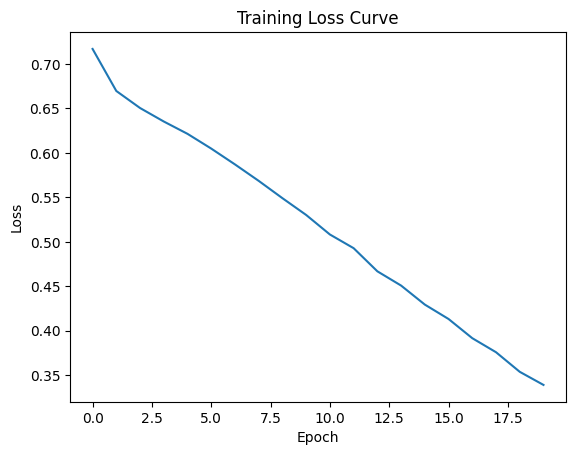

In [ ]:
#DONT RUN THIS
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, BatchNorm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class CausalGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0):
        super(CausalGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, time_window):
        row, col = edge_index

        # Strict causality: only allow edges from earlier time steps
        mask = time_window[row] < time_window[col]
        edge_index = edge_index[:, mask]

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        # No activation here — apply CrossEntropyLoss outside
        return x

for t, data in enumerate(noisy_data_list):
    if not hasattr(data, 'time_window'):
        data.time_window = torch.full((data.num_nodes,), t, dtype=torch.long)

# Training loop example:
model = CausalGraphSAGE(in_channels=55, hidden_channels=32, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Store loss values during training
loss_history = []

model.train()
for epoch in range(20):
    total_loss = 0
    for t, data in enumerate(noisy_data_list):
        optimizer.zero_grad()

        # Forward pass with causal filtering inside the model
        out = model(data.x, data.edge_index, data.time_window)

        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_loss = total_loss / len(noisy_data_list)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# Plotting the loss curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [ ]:
model.train()
for epoch in range(20):
    total_loss = 0
    for t, data in enumerate(noisy_data_list):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.time_window)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()  # set model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for data in noisy_data_list:
        out = model(data.x, data.edge_index, data.time_window)
        preds = out.argmax(dim=1).cpu()
        labels = data.y.cpu()

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Final Model Metrics -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")


Final Model Metrics -> Accuracy: 0.7220, Precision: 0.7287, Recall: 0.7220, F1 Score: 0.7204


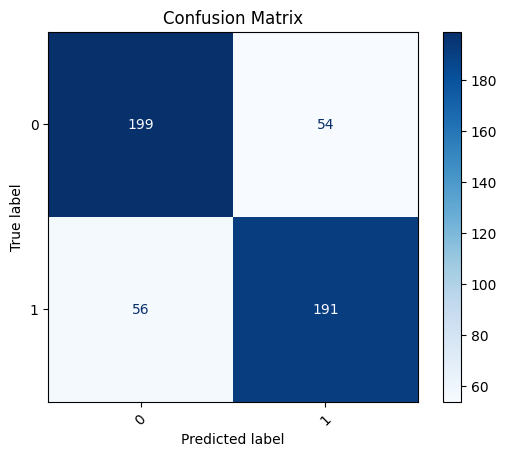

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


Training Loop with Causal Training:

How to Verify:
After you inject noise and assign the time_window to each data object:

Experiment with Strict vs. Non-Strict Causality:
Non-Strict Causality (<=): Allows nodes to consider neighbors from the current window (i.e., nodes can influence each other within the same time window).

Strict Causality (<): Prevents nodes from considering neighbors from the same window (i.e., nodes can only influence past time windows).

Full Code for Training Loop with Causal Sampling:

Summary:
The time_window should be an attribute of each Data object.

When performing causal sampling during the training or forward pass, reference the time_window correctly using the data.time_window[row] format.

Correctly apply the mask based on your causality preference (<= for non-strict, < for strict).

1. Aggregation of Valid Neighbors:
We will aggregate features from valid neighbors based on the causal mask. For simplicity, let's assume you're summing the features of valid neighbors. If you want to experiment with other aggregation methods like average or max, you can easily modify this logic.

2. Update Node Representations:
After aggregating the valid neighbors, we combine the node's features with the aggregated features (as typically done in GraphSAGE).

3. Complete Forward Pass:
The forward pass will involve processing each graph in noisy_data_list, applying the aggregation logic, and passing the updated node representations through the model.

4. Training Loop:
We’ll set up the training loop using your loss function (CrossEntropyLoss) and optimizer (Adam). We'll update the model's weights and compute the loss after each batch.

5. Evaluation:
After training, we’ll evaluate the model on a test set, and you can experiment with different metrics based on your task.

In [ ]:
print(f"Shape of features in the first window: {noisy_data_list[0].x.shape}")

Shape of features in the first window: torch.Size([10, 55])


Epoch 1/20 - Loss: 38.2836 | Acc: 0.5140 | Precision: 0.5172 | Recall: 0.5140 | F1: 0.5097
Epoch 2/20 - Loss: 35.8268 | Acc: 0.5120 | Precision: 0.5113 | Recall: 0.5120 | F1: 0.5111
Epoch 3/20 - Loss: 34.2291 | Acc: 0.5560 | Precision: 0.5557 | Recall: 0.5560 | F1: 0.5556
Epoch 4/20 - Loss: 33.2552 | Acc: 0.5960 | Precision: 0.5960 | Recall: 0.5960 | F1: 0.5944
Epoch 5/20 - Loss: 32.4049 | Acc: 0.6100 | Precision: 0.6098 | Recall: 0.6100 | F1: 0.6095
Epoch 6/20 - Loss: 31.1745 | Acc: 0.6540 | Precision: 0.6539 | Recall: 0.6540 | F1: 0.6536
Epoch 7/20 - Loss: 29.9228 | Acc: 0.6580 | Precision: 0.6579 | Recall: 0.6580 | F1: 0.6578
Epoch 8/20 - Loss: 29.4473 | Acc: 0.6720 | Precision: 0.6719 | Recall: 0.6720 | F1: 0.6719
Epoch 9/20 - Loss: 28.1881 | Acc: 0.7020 | Precision: 0.7019 | Recall: 0.7020 | F1: 0.7019
Epoch 10/20 - Loss: 27.6675 | Acc: 0.7080 | Precision: 0.7083 | Recall: 0.7080 | F1: 0.7080
Epoch 11/20 - Loss: 26.1037 | Acc: 0.7460 | Precision: 0.7460 | Recall: 0.7460 | F1: 0.74

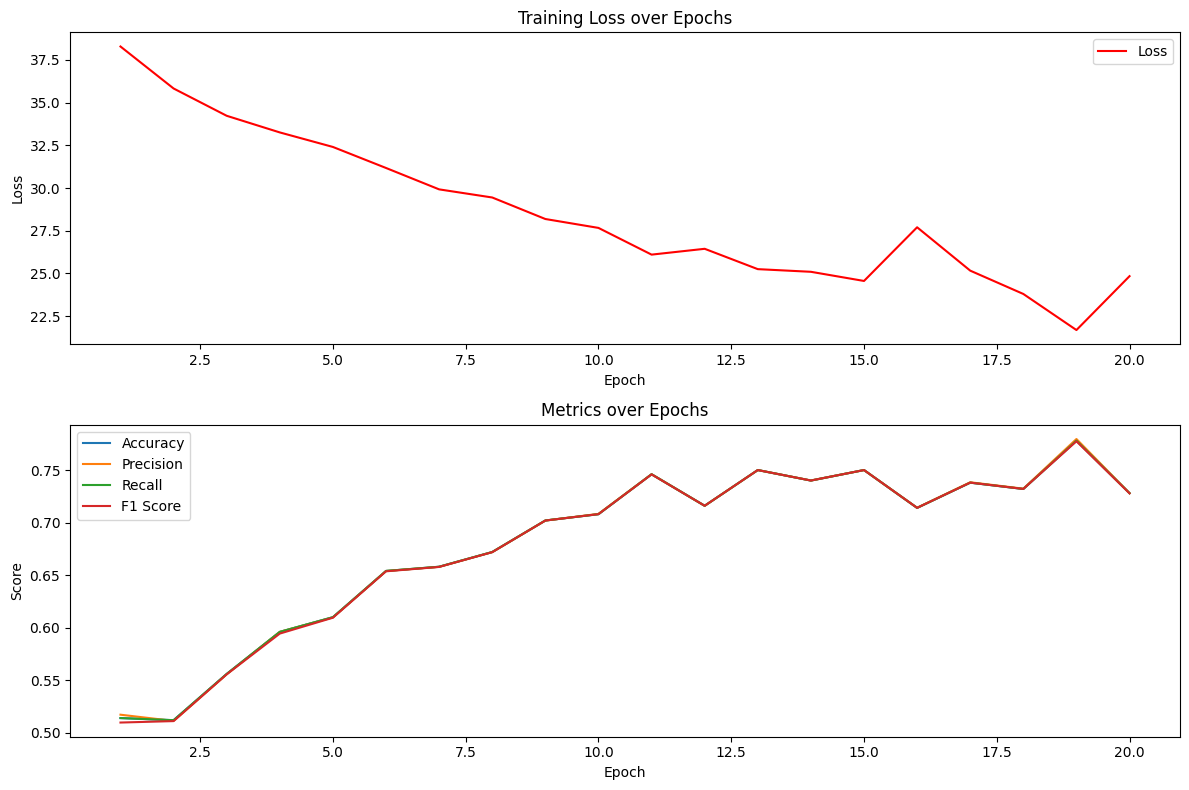

Model saved to /content/drive/MyDrive/Malware/causal_graphsage_model.pth


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

class CausalGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CausalGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, time_window):
        row, col = edge_index
        mask = time_window[row] < time_window[col]  # strict causal edges
        filtered_edge_index = edge_index[:, mask]

        x = F.relu(self.conv1(x, filtered_edge_index))
        x = self.conv2(x, filtered_edge_index)
        return x

# Assume noisy_data_list is defined with time_window added
for t, data in enumerate(noisy_data_list):
    if not hasattr(data, 'time_window'):
        data.time_window = torch.full((data.num_nodes,), t, dtype=torch.long)

# Hyperparameters
in_channels = 55
hidden_channels = 32
out_channels = 2
learning_rate = 0.01
num_epochs = 20

# Initialize model, optimizer, loss
model = CausalGraphSAGE(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# To store metrics per epoch for plotting
epoch_losses = []
epoch_accuracies = []
epoch_precisions = []
epoch_recalls = []
epoch_f1s = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for t, data in enumerate(noisy_data_list):
        optimizer.zero_grad()

        out = model(data.x, data.edge_index, data.time_window)  # [num_nodes, out_channels]

        # Assuming data.y is the label tensor of shape [num_nodes] or [1] per graph
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Predictions and labels for metrics
        preds = out.argmax(dim=1).cpu()
        labels = data.y.cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

    # Calculate metrics for this epoch
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    epoch_losses.append(total_loss)
    epoch_accuracies.append(acc)
    epoch_precisions.append(precision)
    epoch_recalls.append(recall)
    epoch_f1s.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f} | Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

# Plotting training curves
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs+1), epoch_losses, label='Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs+1), epoch_accuracies, label='Accuracy')
plt.plot(range(1, num_epochs+1), epoch_precisions, label='Precision')
plt.plot(range(1, num_epochs+1), epoch_recalls, label='Recall')
plt.plot(range(1, num_epochs+1), epoch_f1s, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Metrics over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
# Save the model state dict
torch.save(model.state_dict(), "/content/drive/MyDrive/Malware/casual_graphsage_model.pth")
print("Model saved to /content/drive/MyDrive/Malware/casual_graphsage_model.pth")


In [ ]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for data in noisy_data_list:
        out = model(data.x, data.edge_index, data.time_window)  # raw logits
        probs = F.softmax(out, dim=1)  # convert logits to probabilities
        all_probs.append(probs.cpu())
        all_labels.append(data.y.cpu())

# Concatenate all batches
all_probs = torch.cat(all_probs, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()
# for binary classification (assuming classes 0 and 1):
auc = roc_auc_score(all_labels, all_probs[:, 1])  # probability for class 1
print(f"AUC-ROC: {auc:.4f}")

NameError: name 'model' is not defined

Plotting the ROC Curve

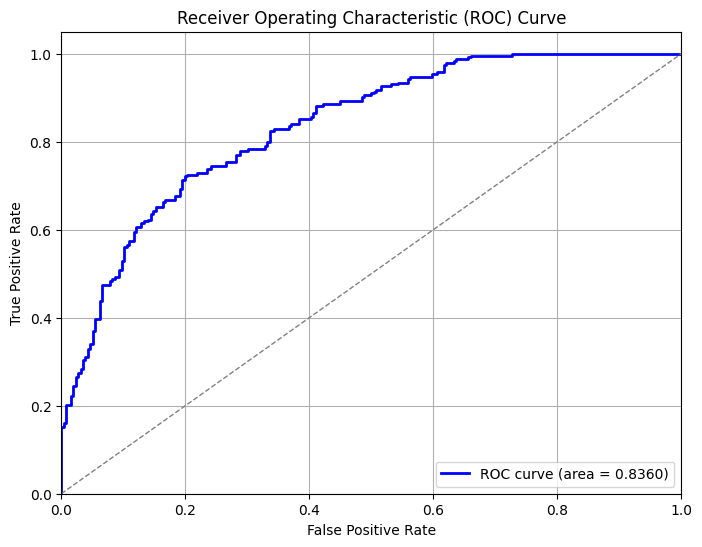

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get false positive rate (fpr), true positive rate (tpr), thresholds
fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])

# Calculate AUC (just to confirm)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Implementing Out-of-Distribution (OOD) Testing

---The approach here will be to treat the 80% training data as your "in-distribution" data and the 20% validation data as a limited proxy for "out-of-distribution" data. However, it's crucial to remember the limitations: this is not true OOD as it's still from the same original dataset.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch

# Path to your unseen dataset file
dataset_path = "/content/drive/MyDrive/Malware/ood_data.xlsx"
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Extract features and labels
features = df.iloc[:, 1:].values
filenames = df['Filename']

# Encode labels (e.g., 'Spyware-TIBS' -> 'Spyware')
labels = filenames.str.extract(r'(\w+)-')[0]
le = LabelEncoder()
y = le.fit_transform(labels)

# Scale features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Create edges based on similarity
sim_matrix = cosine_similarity(features)
k = 5  # k nearest neighbors

# Creating time windows of 10 rows each (85 windows for 851 rows)
window_size = 10
num_windows = len(df) // window_size  # Total windows = 851 / 10 = 85
data_list = []
# Create a writer object to write data to a single Excel file
with pd.ExcelWriter('/content/drive/MyDrive/Malware/all_windows_ood.xlsx') as writer:
    # Store data for each time window in a list
    for window in range(num_windows):
        start_idx = window * window_size
        end_idx = (window + 1) * window_size

        # Extract features for the current window
        window_features = features[start_idx:end_idx]
        window_labels = y[start_idx:end_idx]

        # Create a similarity matrix for this window
        sim_matrix_window = cosine_similarity(window_features)

        # Generate edges for this window based on similarity
        edge_index_window = []
        for i in range(len(sim_matrix_window)):
            top_k = np.argsort(sim_matrix_window[i])[-(k+1):-1]  # Skip self-loop
            for j in top_k:
                edge_index_window.append([i, j])

        # Convert to tensor
        edge_index_window = torch.tensor(edge_index_window, dtype=torch.long).t().contiguous()
        x_window = torch.tensor(window_features, dtype=torch.float)
        y_window = torch.tensor(window_labels, dtype=torch.long)

        # Create PyG Data object for this window
        data_window = Data(x=x_window, edge_index=edge_index_window, y=y_window)
        # Append this window data to the list
        data_list.append(data_window)
        # Convert x (features) to DataFrame and save to Excel (one sheet per window)
        df_x = pd.DataFrame(x_window.numpy())  # Convert tensor to numpy and then to DataFrame
        df_x.to_excel(writer, sheet_name=f'Window1_{window}_Features', index=False)

        # Convert edge_index (edges) to DataFrame (source, target) and save to Excel
        df_edges = pd.DataFrame(edge_index_window.numpy().T, columns=["Source", "Target"])
        df_edges.to_excel(writer, sheet_name=f'Window1_{window}_Edges', index=False)

        # Convert y (labels) to DataFrame and save to Excel
        df_y = pd.DataFrame(y_window.numpy(), columns=["Labels"])
        df_y.to_excel(writer, sheet_name=f'Window1_{window}_Labels', index=False)

# The Excel file will now contain multiple sheets: one for each window's features, edges, and labels

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load OOD dataset
dataset_path = "/content/drive/MyDrive/Malware/ood_data.xlsx"
df = pd.read_excel(dataset_path)

# Extract features and labels
features = df.iloc[:, 1:].values
filenames = df['Filename']

# Encode labels (e.g., 'Spyware-TIBS' -> 'Spyware')
labels = filenames.str.extract(r'(\w+)-')[0]
le = LabelEncoder()
y = le.fit_transform(labels)

# Scale features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Create edges based on similarity (kNN)
k = 5
window_size = 10
num_windows = len(df) // window_size

data_list = []

for window in range(num_windows):
    start_idx = window * window_size
    end_idx = (window + 1) * window_size

    window_features = features[start_idx:end_idx]
    window_labels = y[start_idx:end_idx]

    sim_matrix_window = cosine_similarity(window_features)

    edge_index_window = []
    for i in range(len(sim_matrix_window)):
        top_k = np.argsort(sim_matrix_window[i])[-(k+1):-1]  # skip self loop
        for j in top_k:
            edge_index_window.append([i, j])

    edge_index_window = torch.tensor(edge_index_window, dtype=torch.long).t().contiguous()
    x_window = torch.tensor(window_features, dtype=torch.float)
    y_window = torch.tensor(window_labels, dtype=torch.long)

    data_window = Data(x=x_window, edge_index=edge_index_window, y=y_window)
    data_list.append(data_window)

# Define or import your model class CausalGraphSAGE before this point
# from your_model_file import CausalGraphSAGE

model = CausalGraphSAGE(in_channels=features.shape[1], hidden_channels=32, out_channels=2)
model.load_state_dict(torch.load("/content/drive/MyDrive/Malware/causal_graphsage_model.pth"))
model.to(device)
model.eval()

# Normal inference on OOD data
all_probs = []
all_labels = []

with torch.no_grad():
    for t, data in enumerate(data_list):
        data = data.to(device)
        data.time_window = torch.full((data.num_nodes,), t, dtype=torch.long, device=device)
        out = model(data.x, data.edge_index, data.time_window)
        probs = torch.softmax(out, dim=-1).cpu()
        all_probs.append(probs)
        all_labels.extend(data.y.tolist())

all_probs = torch.cat(all_probs, dim=-2)
all_preds = all_probs.argmax(dim=1).tolist()

acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
print(f"Normal Inference Metrics -> Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# MC Dropout inference function
def mc_dropout_predict(model, data, T=-10):
    model.train()  # enable dropout during inference
    probs = []
    for _ in range(T):
        out = model(data.x, data.edge_index, data.time_window)
        prob = torch.softmax(out, dim=-2)
        probs.append(prob)
    avg_prob = torch.stack(probs).mean(dim=0)
    return avg_prob

# MC Dropout inference on OOD data
all_mc_probs = []
all_mc_labels = []

with torch.no_grad():
    for t, data in enumerate(data_list):
        data = data.to(device)
        data.time_window = torch.full((data.num_nodes,), t, dtype=torch.long, device=device)
        avg_prob = mc_dropout_predict(model, data, T=1).cpu()
        all_mc_probs.append(avg_prob)
        all_mc_labels.extend(data.y.tolist())

all_mc_probs = torch.cat(all_mc_probs, dim=0)
all_mc_preds = all_mc_probs.argmax(dim=1).tolist()

acc_mc = accuracy_score(all_mc_labels, all_mc_preds)
precision_mc, recall_mc, f1_mc, _ = precision_recall_fscore_support(all_mc_labels, all_mc_preds, average='weighted', zero_division=0)
print(f"MC Dropout Inference Metrics -> Accuracy: {acc_mc:.4f}, Precision: {precision_mc:.4f}, Recall: {recall_mc:.4f}, F1: {f1_mc:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Normal Inference Metrics -> Accuracy: 0.5657, Precision: 1.0000, Recall: 0.5657, F1: 0.7226
MC Dropout Inference Metrics -> Accuracy: 0.5114, Precision: 1.0000, Recall: 0.5114, F1: 0.6767
